In [55]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
df = pd.read_csv('AAPL_2006-01-01_to_2018-01-01 (1).csv')
df.Month = pd.to_datetime(df.Date)
df = df.set_index("Date")
df=df.drop(['Open', 'High', 'Low', 'Volume', 'Name'], axis=1)
df.head()

,Close
Date,
2006-01-03,10.68
2006-01-04,10.71
2006-01-05,10.63
2006-01-06,10.90
2006-01-09,10.86


In [40]:
df.index.freq = 'MS'

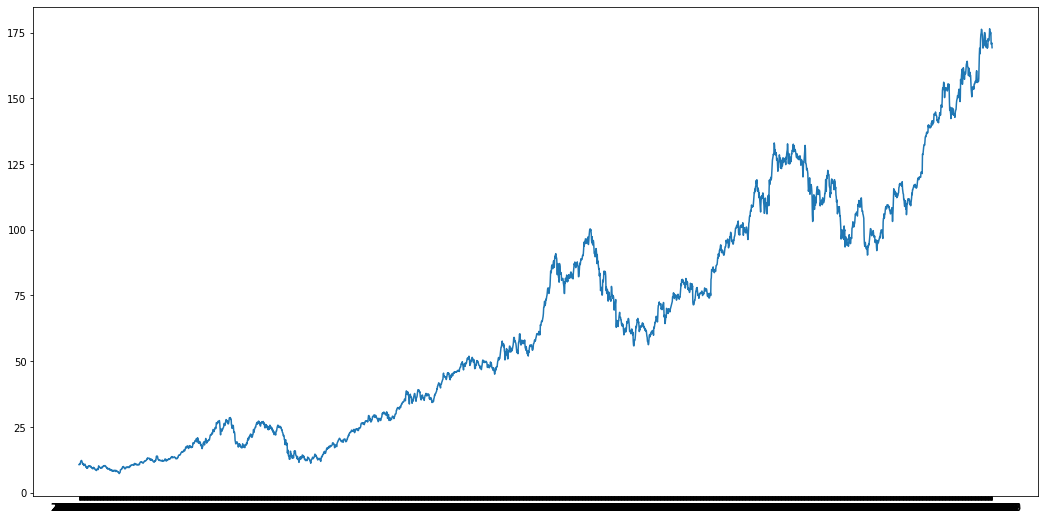

In [41]:
plt.figure(figsize=(18,9))
plt.plot(df.index, df["Close"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show();

In [42]:
a = seasonal_decompose(df["Close"] )
a.plot();

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

NameError: name 'a' is not defined

<Figure size 1152x504 with 0 Axes>

In [57]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [45]:
arima_model = SARIMAX(train_data['Close'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      Close   No. Observations:                 3007
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -4712.810
Date:                                    Thu, 14 Jul 2022   AIC                           9447.621
Time:                                            09:40:06   BIC                           9513.713
Sample:                                                 0   HQIC                          9471.391
                                                   - 3007                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7188      0.420      1.711      0.087      -0.105       1.542
ar.L2         -0.0312      0.013     -2.340      0.019      -0.057      -0.005
ma.L1         -0.6919      0.420     -1.646      0.100      -1.516       0.132
ar.S.L12       0.4964      0.074      6.686      0.000       0.351       0.642
ar.S.L24       0.5754      0.043     13.430      0.000       0.491       0.659
ar.S.L36      -0.8967      0.065    -13.750      0.000      -1.024      -0.769
ar.S.L48      -0.0076      0.017     -0.454      0.650      -0.041       0.025
ma.S.L12      -0.5048      0.073     -6.886      0.000      -0.649      -0.361
ma.S.L24      -0.5720      0.048    -11.817      0.000      -0.667      -0.477
ma.S.L36       0.8781      0.069     12.682      0.000       0.742       1.014
sigma2         1.3469      0.017     77.440      0.000       1.313       1.381
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6809.09
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              11.41   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

3007    171.626650
3008    171.725136
3009    171.883224
3010    171.917052
3011    171.754009
3012    171.725477
3013    171.595100
3014    171.718121
3015    171.639015
3016    171.411862
3017    171.547084
3018    171.655308
Name: ARIMA Predictions, dtype: float64

In [49]:
arima_rmse_error = rmse(test_data['Close'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 5.861670147490638
RMSE Error: 2.4210886285905846
Mean: 64.66289168598874


In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

<AxesSubplot:xlabel='Date'>

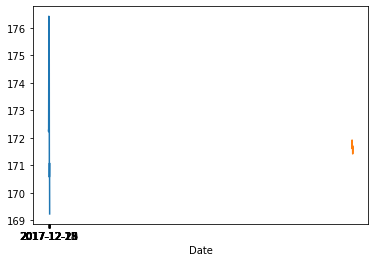

In [51]:
test_data['Close'].plot()
arima_pred.plot()

In [58]:
# train_data = train_data['Close']
# test_data = test_data['Close']
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [59]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
 

lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

ValueError: Input 0 of layer "lstm_3" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)

In [61]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
2995/2995 [==============================] - 19s 6ms/step - loss: 0.0012
Epoch 2/20
2995/2995 [==============================] - 19s 6ms/step - loss: 2.3253e-04
Epoch 3/20
2995/2995 [==============================] - 19s 6ms/step - loss: 1.7799e-04
Epoch 4/20
2995/2995 [==============================] - 19s 6ms/step - loss: 1.5402e-04
Epoch 5/20
2995/2995 [==============================] - 19s 6ms/step - loss: 1.2917e-04
Epoch 6/20
2995/2995 [==============================] - 20s 7ms/step - loss: 1.0897e-04
Epoch 7/20
2995/2995 [==============================] - 19s 6ms/step - loss: 1.1657e-04
Epoch 8/20
2995/2995 [==============================] - 20s 7ms/step - loss: 9.2616e-05
Epoch 9/20
2995/2995 [==============================] - 18s 6ms/step - loss: 9.1185e-05
Epoch 10/20
2995/2995 [==============================] - 19s 6ms/step - loss: 8.0598e-05
Epoch 11/20
2995/2995 [==============================] - 19s 6ms/step - loss: 8.1726e-05
Epoch 12/20
2995/2995 [===========

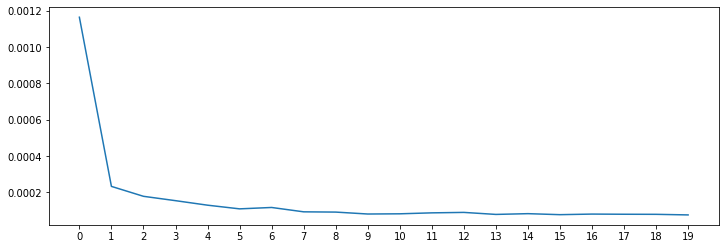

In [62]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [63]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [64]:
lstm_predictions_scaled

[array([0.96448714], dtype=float32),
 array([0.95642066], dtype=float32),
 array([0.9480364], dtype=float32),
 array([0.9391844], dtype=float32),
 array([0.92989045], dtype=float32),
 array([0.9202249], dtype=float32),
 array([0.9102979], dtype=float32),
 array([0.90020853], dtype=float32),
 array([0.8900134], dtype=float32),
 array([0.8797429], dtype=float32),
 array([0.86949676], dtype=float32),
 array([0.8593071], dtype=float32)]

In [65]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[170.23832588],
       [168.87509154],
       [167.45814698],
       [165.96216821],
       [164.39148669],
       [162.75800895],
       [161.08034014],
       [159.37524204],
       [157.65226405],
       [155.91655355],
       [154.18495291],
       [152.46290164]])

In [66]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data['ARIMA_Predictions'] = arima_pred

In [67]:
l = []
for i in arima_pred:
    l.append(i)
test_data['ARIMA_Predictions'] = l
test_data


,Close,LSTM_Predictions,ARIMA_Predictions
Date,,,
2017-12-13,172.27,170.238326,171.626650
2017-12-14,172.22,168.875092,171.725136
2017-12-15,173.97,167.458147,171.883224
2017-12-18,176.42,165.962168,171.917052
2017-12-19,174.54,164.391487,171.754009
2017-12-20,174.35,162.758009,171.725477
2017-12-21,175.01,161.080340,171.595100
2017-12-22,175.01,159.375242,171.718121
2017-12-26,170.57,157.652264,171.639015


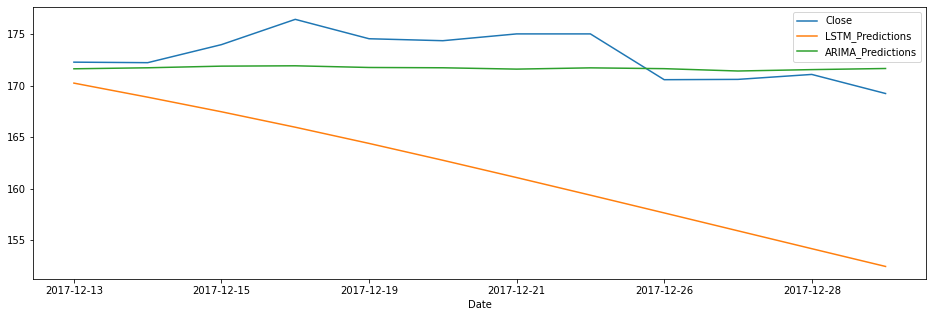

In [68]:
test_data['Close'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);
test_data['ARIMA_Predictions'].plot(legend = True);

In [69]:
lstm_rmse_error = rmse(test_data['Close'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 149.3319960355735
RMSE Error: 12.220147136412617
Mean: 64.66289168598874
